## 0. Import the packages needed

In [291]:
import json
import requests
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import numpy as np

## 1. Get trading calendar

In [2]:
import tushare as ts
# token = '888888888888888'
# pro = ts.pro_api('888888888888888888888888')

In [319]:
cal = pro.trade_cal(exchange='', start_date='20190701', end_date='20220211', fields='cal_date', is_open='1')
cal = pd.to_datetime(cal.cal_date)
cal

0     2019-07-01
1     2019-07-02
2     2019-07-03
3     2019-07-04
4     2019-07-05
         ...    
631   2022-02-07
632   2022-02-08
633   2022-02-09
634   2022-02-10
635   2022-02-11
Name: cal_date, Length: 636, dtype: datetime64[ns]

## 2. Get ETF volume data

In [336]:
def get_etf_vol(date,code):
    params = {
        'jsonCallBack': 'jsonpCallback39629019',
        'sqlId': 'COMMON_SSE_ZQPZ_ETFZL_XXPL_ETFGM_SEARCH_L',
        'STAT_DATE': date,
        }
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
        'Accept': '*/*',
        'Accept-Language': 'zh-CN,zh;q=0.8,zh-TW;q=0.7,zh-HK;q=0.5,en-US;q=0.3,en;q=0.2',
        'Referer': 'http://www.sse.com.cn/'
        }

    root_url = 'http://query.sse.com.cn/commonQuery.do'
    
    r = requests.get(url=root_url, headers=headers, params=params)
    r = r.content.decode()
    r = json.loads(re.findall('\((.*?)\)', r)[0])
    try:
        etf_vol = [info for info in r['result'] if info['SEC_CODE'] == code][0]['TOT_VOL']
    except:
        etf_vol = None
        
    vol_dict = {'date':date, 'vol':etf_vol}
    return vol_dict

In [337]:
get_etf_vol('2020-08-04','512170')

{'date': '2020-08-04', 'vol': '89494.02'}

In [339]:
def etf_vol_crawler(calendar,code):
    '''
    calendar: an iterable datetime sequence
    code: fund code in string format
    
    '''
    etf_vol_ls = list()
    for date in calendar:
        date = str.split(str(date))[0]
        etf_vol_ls.append(get_etf_vol(date,code))
        
    vol_final = pd.DataFrame(etf_vol_ls)
        
    return vol_final

In [340]:
vol_final = etf_vol_crawler(cal,'512170')
vol_final.date = pd.to_datetime(vol_final.date)
vol_final.vol = pd.to_numeric(vol_final.vol)

In [341]:
vol_final

,date,vol
0,2019-07-01,6794.02
1,2019-07-02,6744.02
2,2019-07-03,6594.02
3,2019-07-04,6544.02
4,2019-07-05,6532.92
...,...,...
631,2022-02-07,2323682.05
632,2022-02-08,2351182.05
633,2022-02-09,2370282.05
634,2022-02-10,2407882.05


In [345]:
vol_final.loc[vol_final.date == '2020-08-04']

,date,vol
267,2020-08-04,89494.02


Text(0.5, 1.0, '医疗ETF规模')

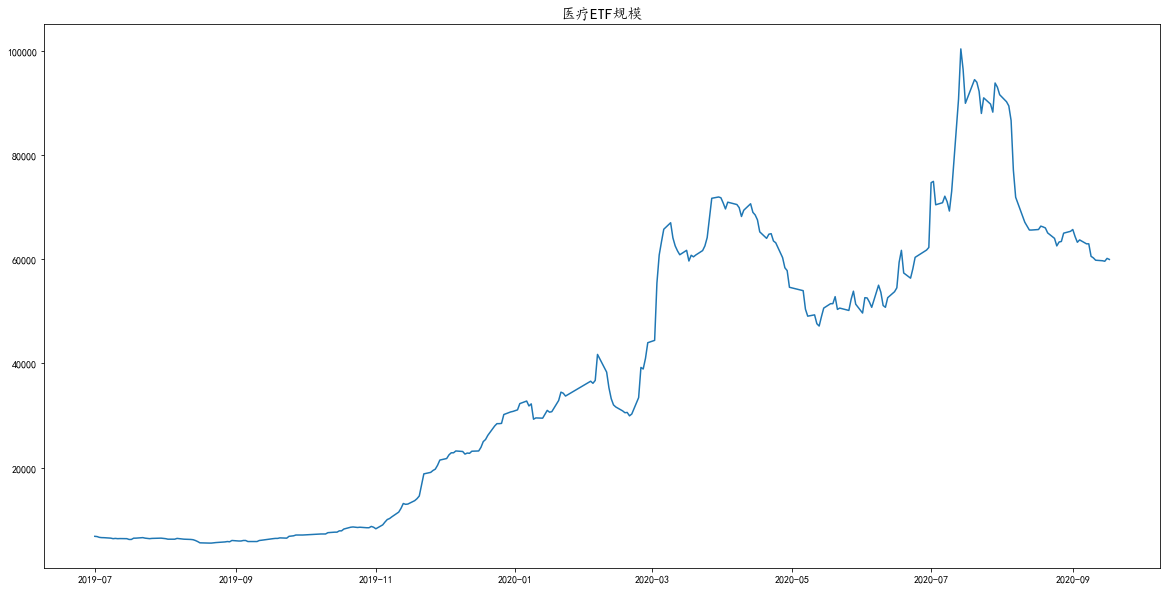

In [417]:
plt.figure(figsize=(20,10))
plt.plot(vol_final[:300].date, vol_final[:300].vol)
plt.title('医疗ETF规模',fontdict={'fontsize':15})

## 3. Get ETF value data

In [22]:
import time

In [273]:
def get_etf_value(code,page,start,end):
        
    value_url = 'http://api.fund.eastmoney.com/f10/lsjz?\
callback=jQuery183023176955335716132_1644507388843\
&fundCode={}\
&pageIndex={}\
&pageSize=20\
&startDate={}\
&endDate={}'.format(code,page,start,end)
    
    headers = {
        'Accept': '*/*',
        'Accept-Encoding': 'gzip, deflate',
        'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6',
        'Host': 'api.fund.eastmoney.com',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36',
        'Referer': 'http://fundf10.eastmoney.com/jjjz_320007.html'
        }
    r = requests.get(value_url, headers=headers)
    r = r.content.decode()
    r = pd.DataFrame(json.loads(re.findall('\((.*?)\)', r)[0])['Data']['LSJZList'])
    
    value_dict = {'date':r['FSRQ'], 'value':r['LJJZ']}
    
    return pd.DataFrame(value_dict)

In [347]:
etf_value_ls = list()
for page in range(1,100):
    try:
        etf_value_ls.append(get_etf_value(512170,page,'2019-07-01','2022-02-11'))
    except:
        break
        
# value_final = pd.concat(etf_value_ls)

In [348]:
value_final = pd.concat(etf_value_ls)

In [349]:
value_final.date = pd.to_datetime(value_final.date)
value_final.value = pd.to_numeric(value_final.value)

Text(0.5, 1.0, '医疗ETF单位净值')

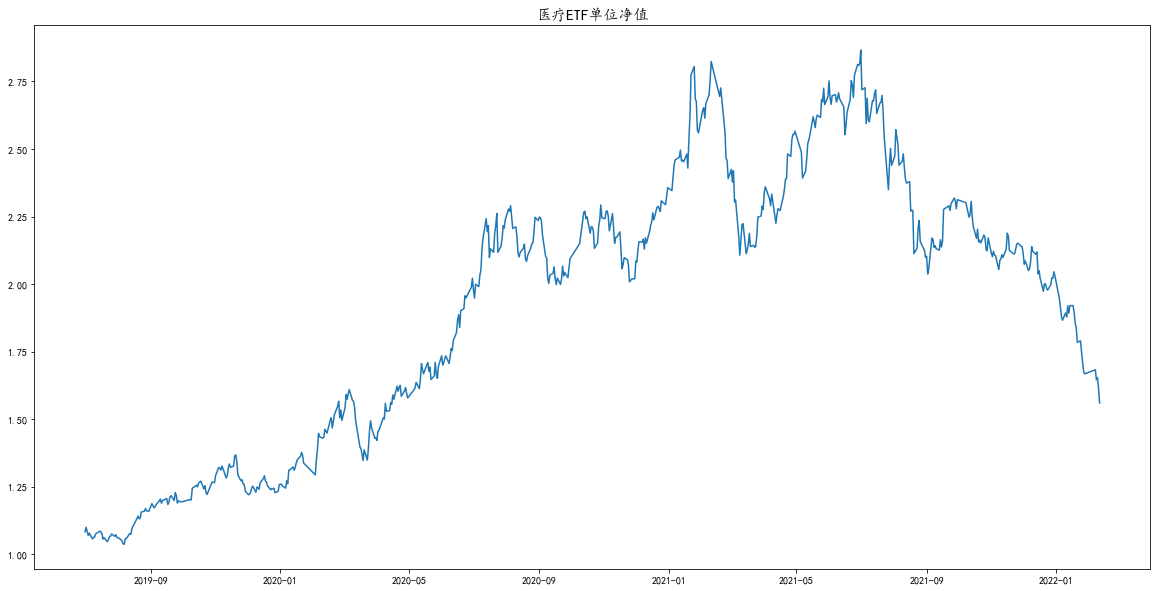

In [418]:
plt.figure(figsize=(20,10))
plt.plot(value_final.date, value_final.value)
plt.title('医疗ETF单位净值',fontdict={'fontsize':15})

## 4. Analysis

In [351]:
final = pd.merge(vol_final,value_final)

In [352]:
final.set_index('date',inplace=True)

In [353]:
final

,vol,value
date,,
2019-07-01,6794.02,1.0839
2019-07-02,6744.02,1.1003
2019-07-03,6594.02,1.0855
2019-07-04,6544.02,1.0707
2019-07-05,6532.92,1.0789
...,...,...
2022-02-07,2323682.05,1.6833
2022-02-08,2351182.05,1.6464
2022-02-09,2370282.05,1.6545


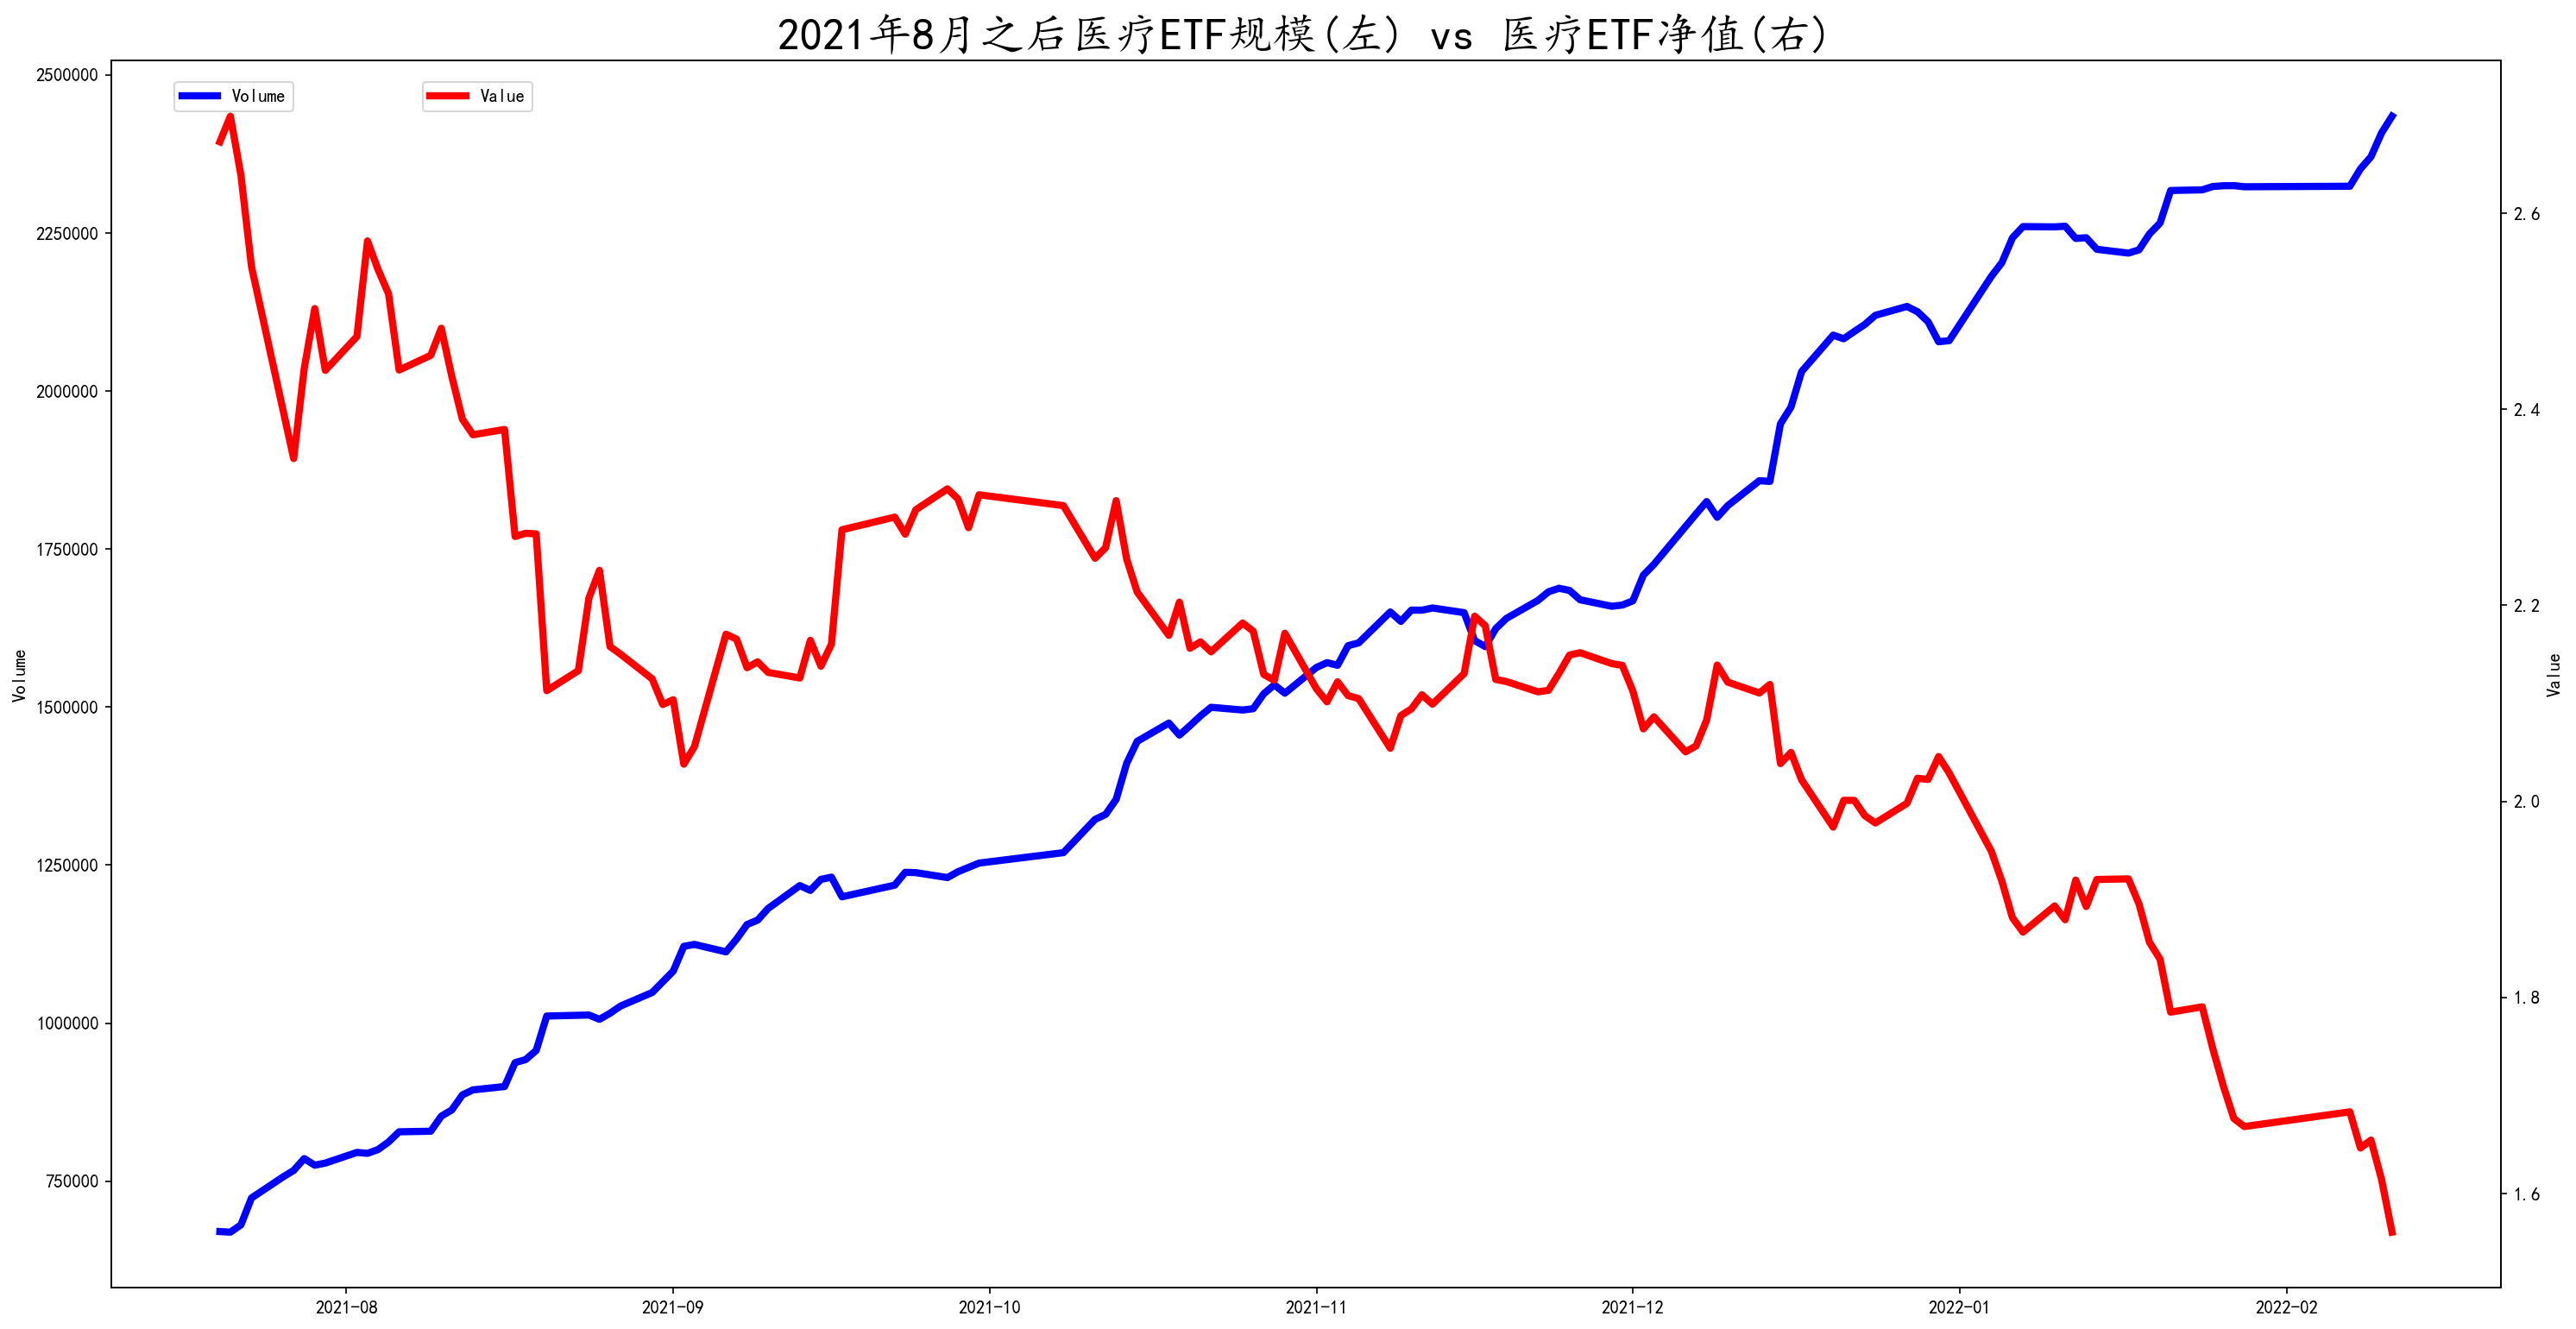

In [420]:
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体

fig, ax1 = plt.subplots(dpi=150,figsize=(20,10))

ax1.set_ylabel('Volume')
ax1.plot(final['vol'][500:],label='Volume',color='blue',linewidth=4)
plt.legend(bbox_to_anchor=(0.08, 0.99))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Value')
ax2.plot(final['value'][500:],label='Value',color='red',linewidth=4)

fig.tight_layout()
plt.legend(bbox_to_anchor=(0.18, 0.99),)

plt.title('2021年8月之后医疗ETF规模(左) vs 医疗ETF净值(右)',fontdict={'fontsize':25})

Text(0.5, 1, '2021年之前医疗ETF规模(左) vs 医疗ETF净值(右)')

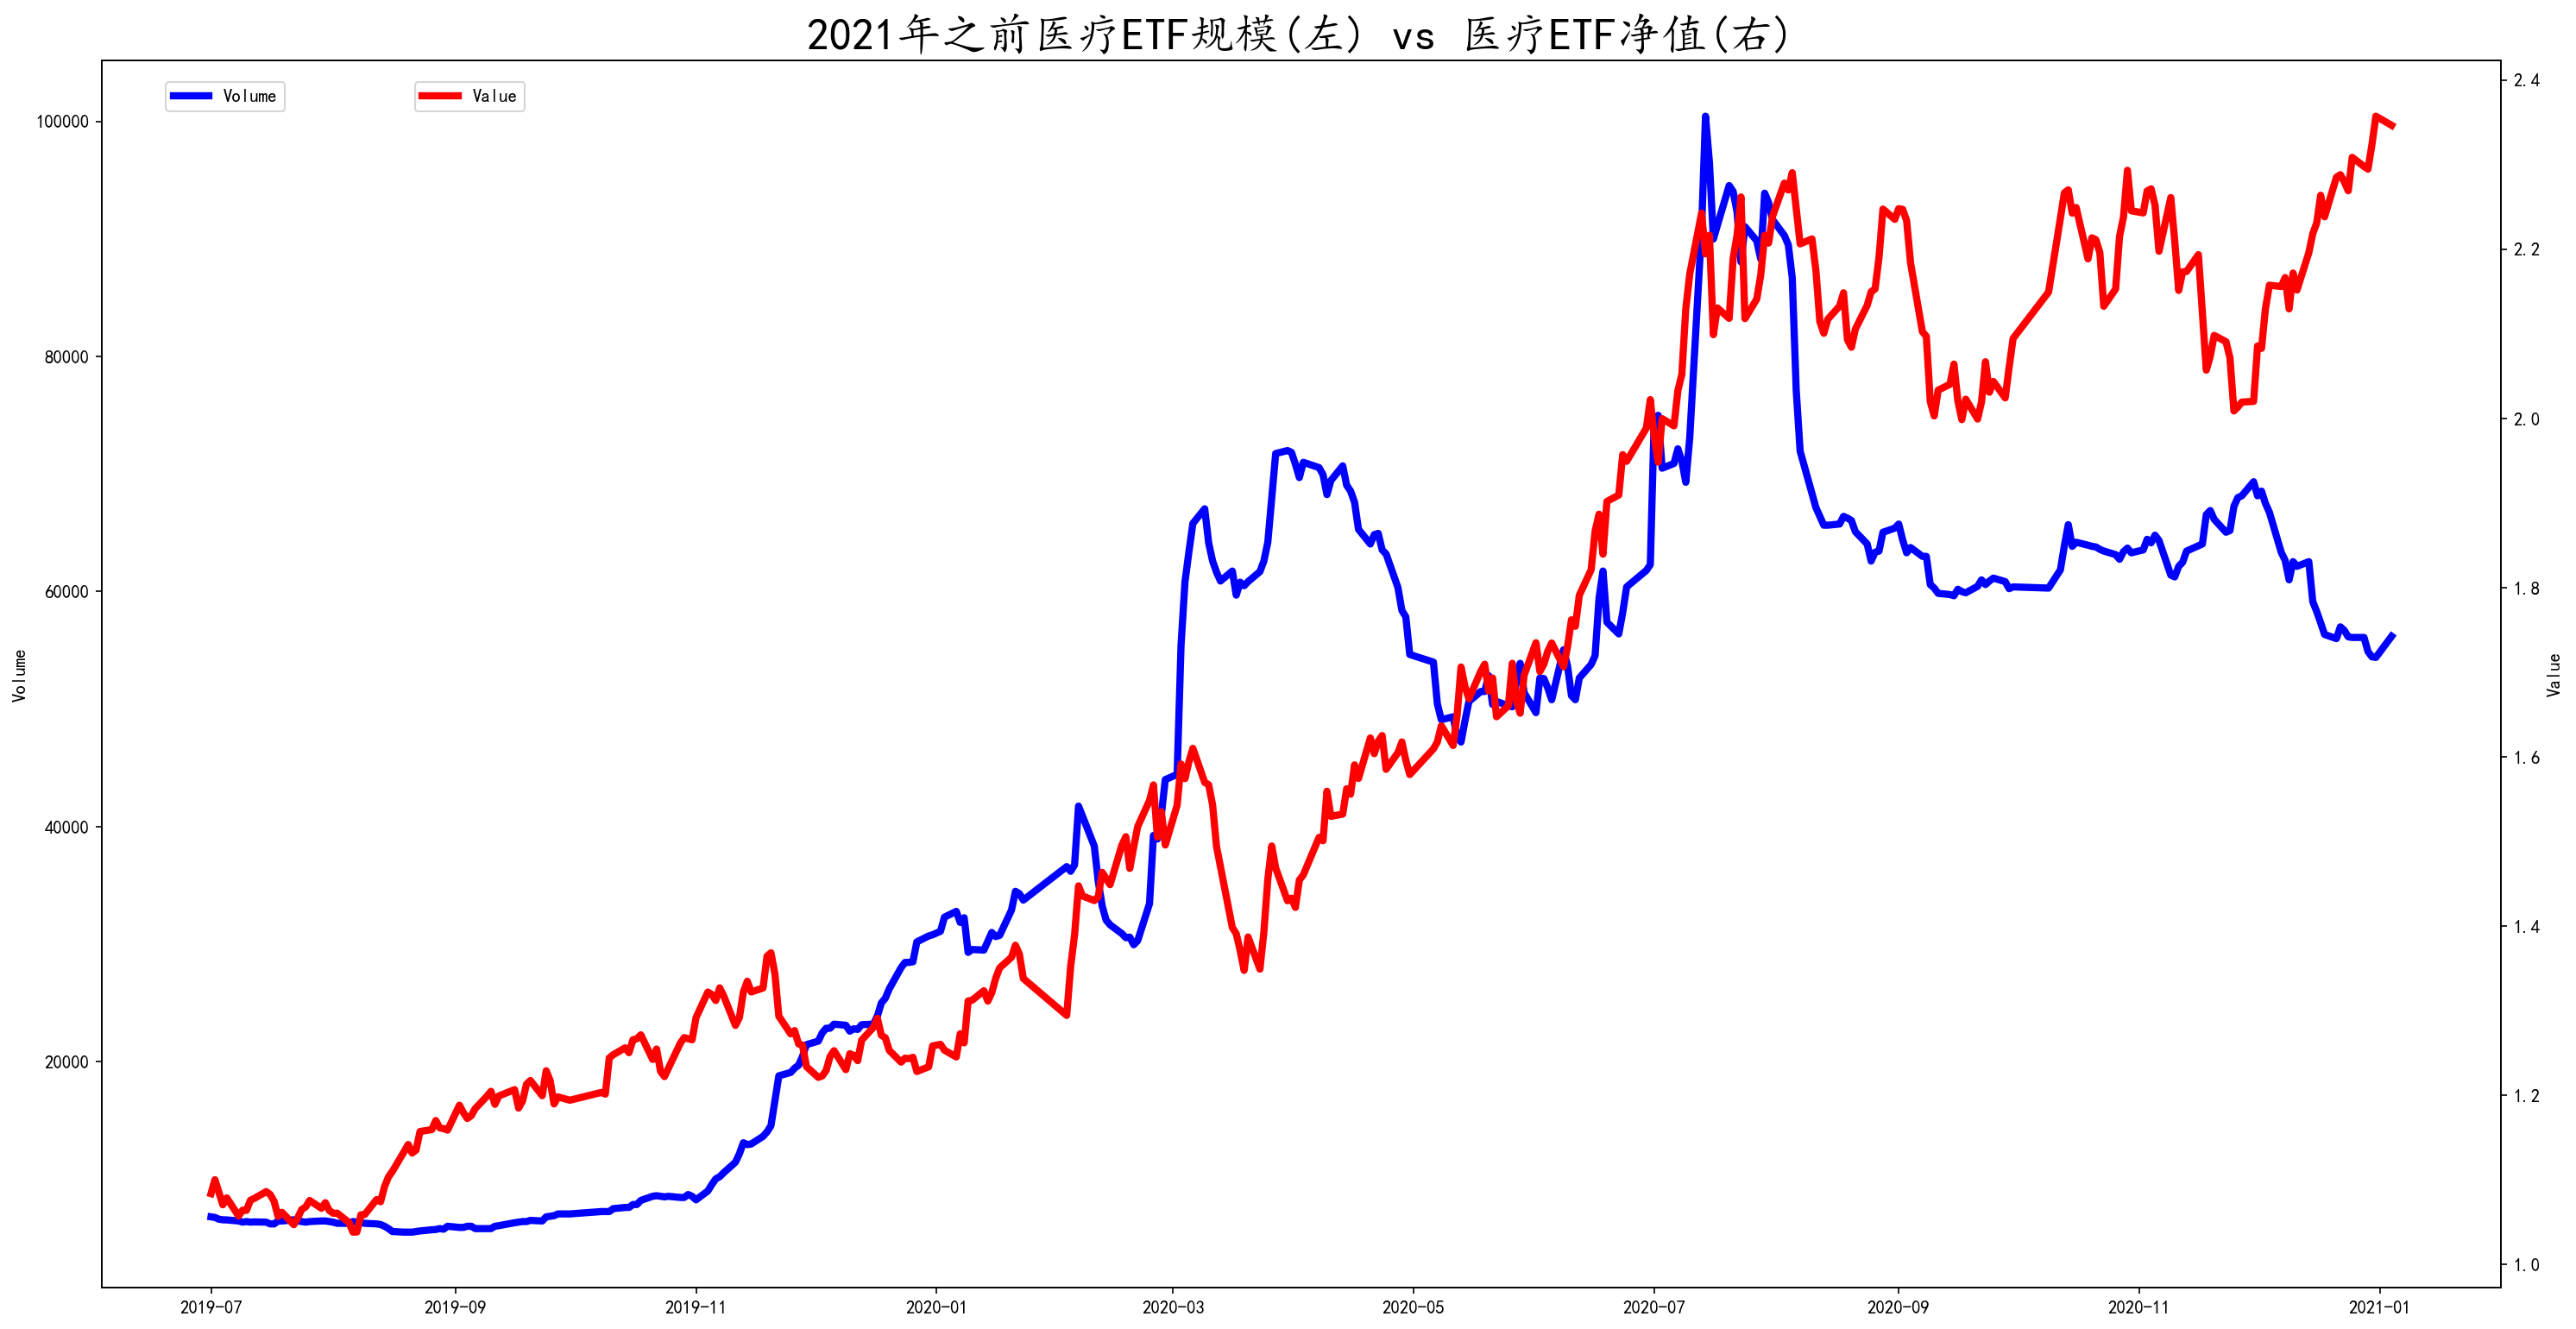

In [369]:
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体

fig, ax1 = plt.subplots(dpi=150,figsize=(20,10))

ax1.set_ylabel('Volume')
ax1.plot(final['vol'][:370],label='Volume',color='blue',linewidth=4)
plt.legend(bbox_to_anchor=(0.08, 0.99))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Value')
ax2.plot(final['value'][:370],label='Value',color='red',linewidth=4)

fig.tight_layout()
plt.legend(bbox_to_anchor=(0.18, 0.99),)

plt.title('2021年之前医疗ETF规模(左) vs 医疗ETF净值(右)',fontdict={'fontsize':25})

In [405]:
corr_series = final['vol'].rolling(200).corr(final['value'])

Text(0.5, 1.0, '200个交易日滚动相关系数')

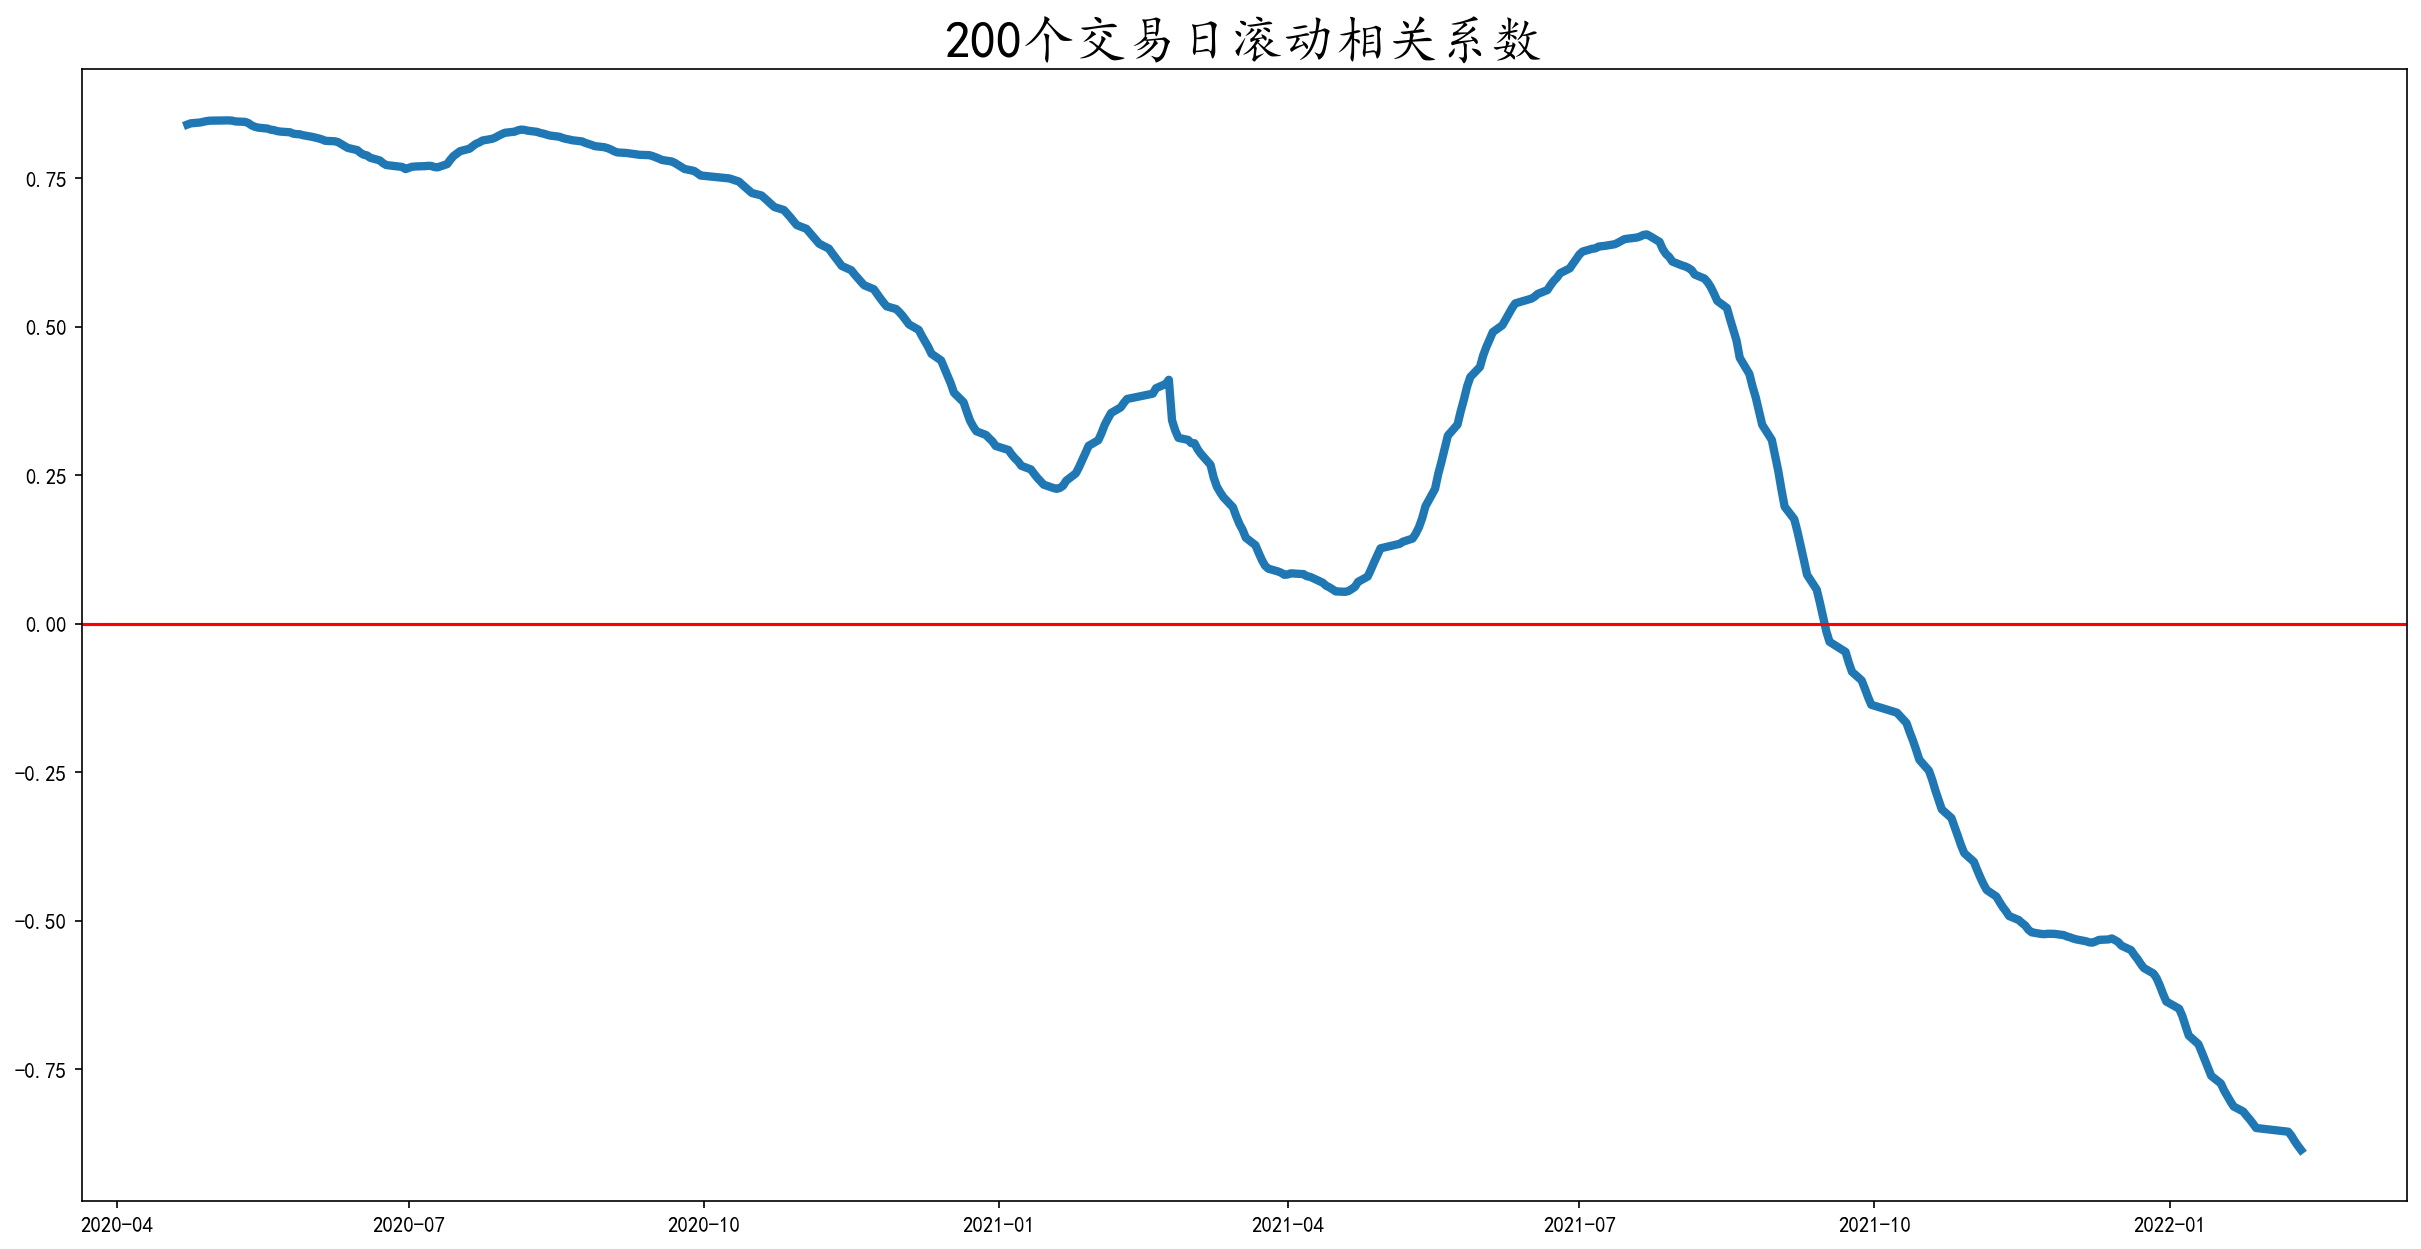

In [414]:
plt.rcParams['axes.unicode_minus']=False # 解决负号显示问题
plt.figure(dpi=150,figsize=(20,10))
plt.plot(corr_series,linewidth=4)
plt.axhline(y = 0,color='red')

plt.title('200个交易日滚动相关系数',fontdict={'fontsize':25})

Text(0.5, 1.0, '医疗ETF规模(水平) vs 医疗ETF净值(垂直)')

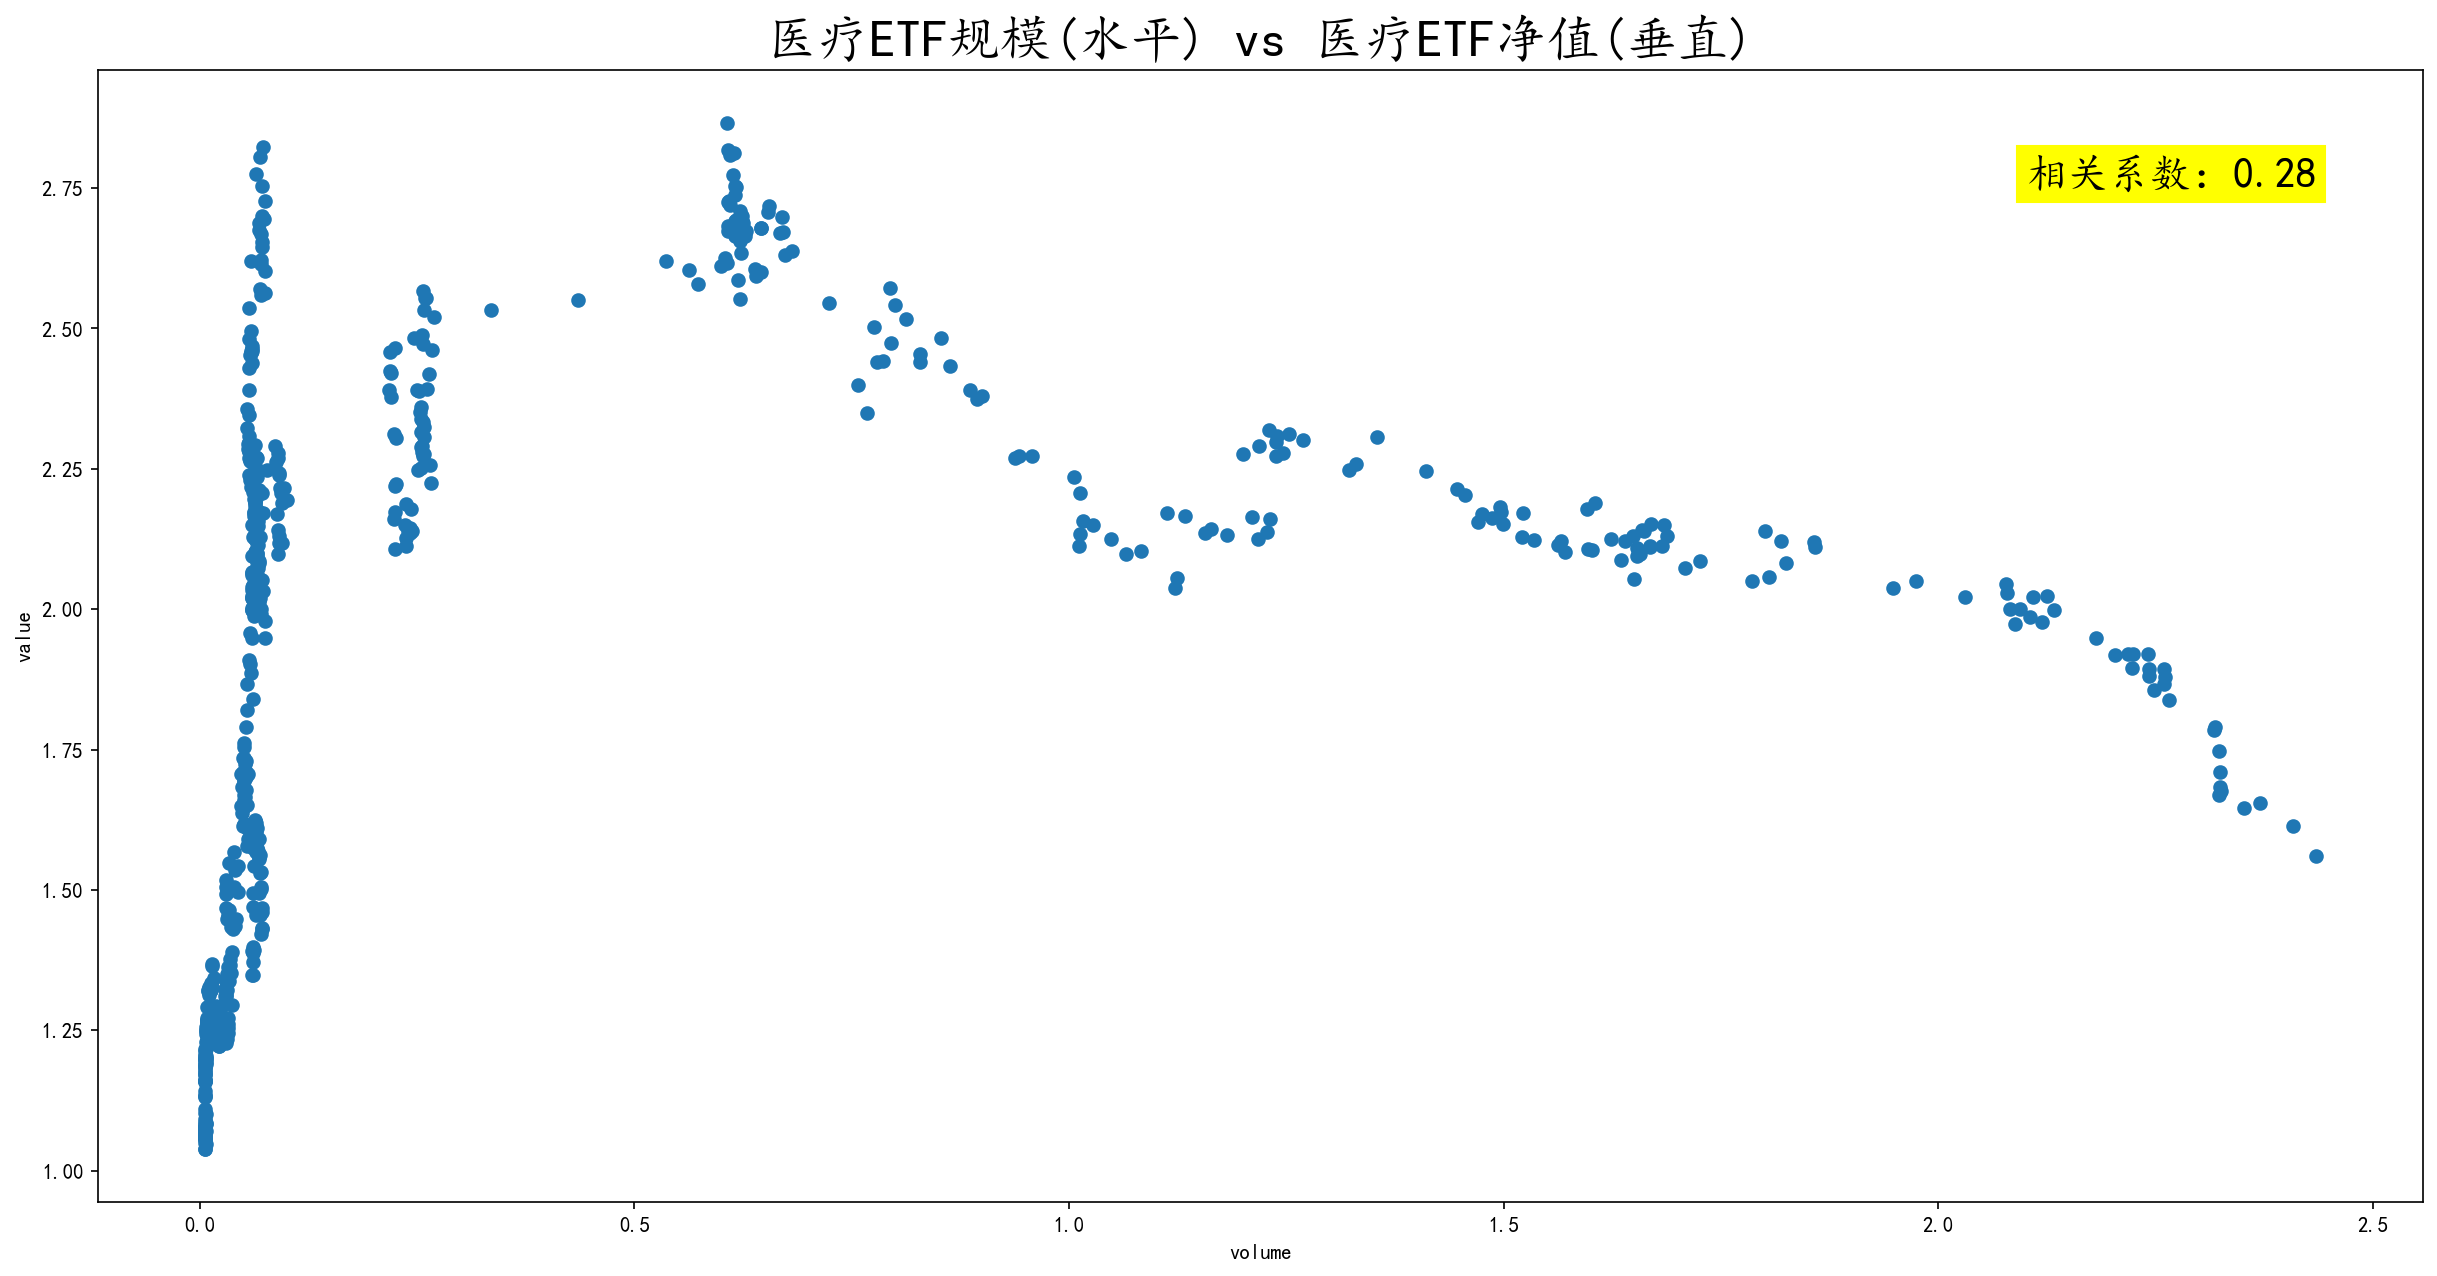

In [415]:
plt.figure(dpi=150,figsize=(20,10))
plt.scatter(final['vol']/1000000,final['value'])
plt.text(2.1,2.75,'相关系数：0.28',backgroundcolor='yellow',fontdict={'fontsize':20})
plt.xlabel('volume')
plt.ylabel('value')
plt.title('医疗ETF规模(水平) vs 医疗ETF净值(垂直)',fontdict={'fontsize':25})